## Importando as bibliotecas

In [1]:
import msgpack
import numpy as np
import pandas as pd
from typing import Dict, Any, Optional
from matplotlib import pyplot as plt
from collections import OrderedDict

from geexhp.conversores import converter_configuracao
from geexhp.modificadores import mod_telescopio, mod_valor_gas, modificador_aleatorio
from geexhp.analisadores import EspectroAnalise
from geexhp.datagen import datagen
from geexhp.pypsg import PSG

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [13]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))
    
config_df = converter_configuracao(config)

In [4]:
#api_user: str = "https://10.2.180.164/api.php"
psg = PSG(timeout_seconds = 200)

Testing connection to PSG at https://psg.gsfc.nasa.gov/api.php ...
Connected to PSG with success.


In [20]:
config_HWC = config.copy()
mod_telescopio(config_HWC, instrumento='HWC')     # HabEx Workforce Camera (HWC)
resultado = psg.run(config_HWC)

In [21]:
spectrum = EspectroAnalise(resultado)
spectrum.converter_para_dataframe()

,Wave/freq [um],Total [I/F apparent albedo],Noise,Planet
0,0.370000,0.102022,0.129523,0.102022
1,0.370370,0.101932,0.130016,0.101932
2,0.370740,0.101843,0.130330,0.101843
3,0.371111,0.101752,0.130759,0.101752
4,0.371482,0.101661,0.132349,0.101661
...,...,...,...,...
1578,1.791332,0.005067,0.485152,0.005067
1579,1.793123,0.001620,0.487056,0.001620
1580,1.794916,0.003894,0.489079,0.003894
1581,1.796711,0.003114,0.491635,0.003114


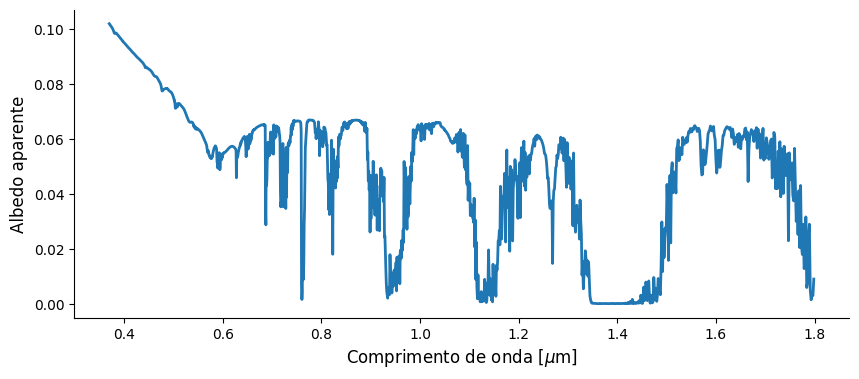

In [22]:
spectrum.plotar_espectro();

In [25]:
# Função auxiliar para podermos fazer nossos testes
def run_simulation(config: Dict[str, Any], instrumento: str, 
                   gas: Optional[str] = None, gas_value: Optional[float] = None,
                   atm_pressure: Optional[float] = None) -> 'EspectroAnalise':
    config_sim = config.copy()
    if gas is not None and gas_value is not None:
        mod_valor_gas(config_sim, gas, gas_value)
    if atm_pressure is not None:
        config_sim["ATMOSPHERE-PRESSURE"] = atm_pressure * 1000
    if instrumento != "SS-Vis":
        mod_telescopio(config_sim, instrumento)
    resultado = psg.run(config_sim)
    return EspectroAnalise(resultado)

In [16]:
# UV (0.2 to 0.45 um) 
df_SSUV = run_simulation(config, instrumento="SS-UV").converter_para_dataframe()
# Visible (0.45 to 1um)
df_SSVis = run_simulation(config, instrumento="SS-Vis").converter_para_dataframe()
# Infrared (0.975 to 1.8 um)
df_SSNIR = run_simulation(config, instrumento="SS-NIR").converter_para_dataframe()

df = pd.concat([df_SSUV, df_SSVis, df_SSNIR]).reset_index(drop=True)

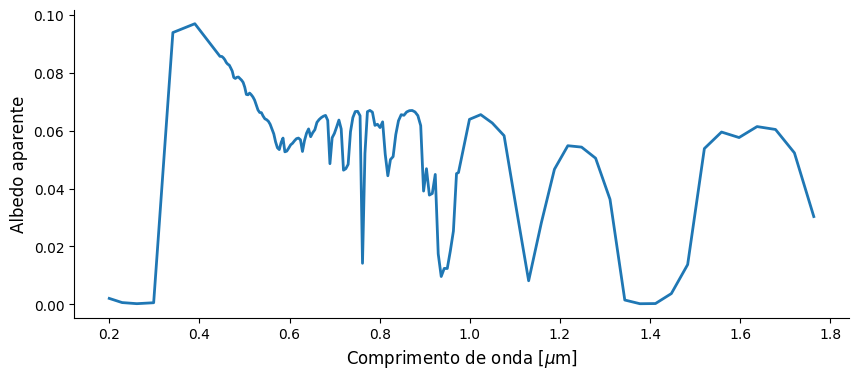

In [17]:
wave_freq = df["Wave/freq [um]"]
total_albedo = df["Total [I/F apparent albedo]"]
erro = df["Noise"]

_, ax = plt.subplots()
ax.plot(wave_freq, total_albedo, color="tab:blue", lw=2)
ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente");

## Teste 2 - Mudando as abundâncias

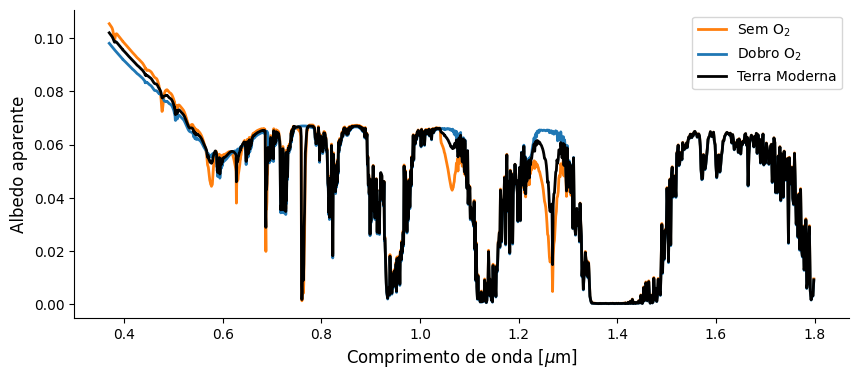

In [23]:
# Dobrando o valor de O2
resultado_dobro_O2 = run_simulation(config, instrumento="HWC", gas="O2", gas_value=2)

# Tirando O2 da atmosfera
resultado_sem_O2 = run_simulation(config, instrumento="HWC", gas="O2", gas_value=0)

_, ax = plt.subplots()
resultado_dobro_O2.plotar_espectro(ax=ax, label="Sem O${}_2$", cor_linha="tab:orange")
resultado_sem_O2.plotar_espectro(ax=ax, label="Dobro O${}_2$", cor_linha="tab:blue")
spectrum.plotar_espectro(ax=ax, label="Terra Moderna", cor_linha="k")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

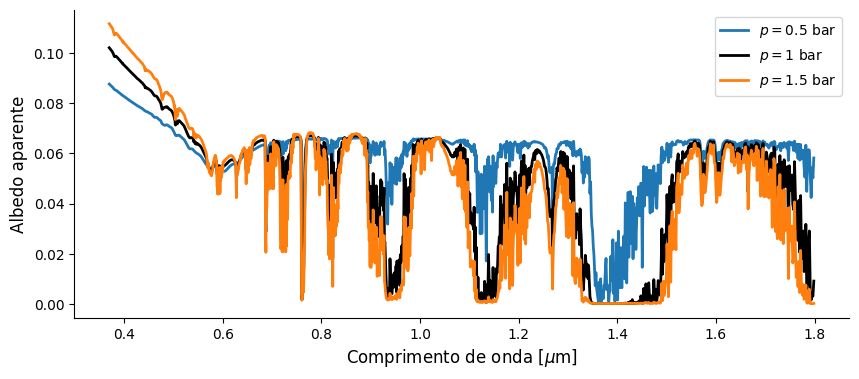

In [26]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
resultado_metade_atm = run_simulation(config, instrumento='HWC', atm_pressure=0.5)
resultado_15_atm = run_simulation(config, instrumento='HWC', atm_pressure=1.5)

_, ax = plt.subplots()
resultado_metade_atm.plotar_espectro(ax=ax, label="$p = 0.5$ bar", cor_linha="tab:blue")
spectrum.plotar_espectro(ax=ax, label="$p = 1$ bar", cor_linha="black")
resultado_15_atm.plotar_espectro(ax=ax, label="$p = 1.5$ bar", cor_linha="tab:orange")
ax.legend();

Quando a pressão atmosférica diminui, é geralmente um indicativo de uma atmosfera mais rarefeita. Em contrapartida, uma pressão atmosférica mais elevada sugere uma atmosfera mais densa e expansiva. A correlação entre a densidade atmosférica e a visibilidade das assinaturas espectrais está intrinsecamente ligada à interação fóton-molécula. Em uma atmosfera densa, as moléculas presentes têm mais oportunidades de interagir com os fótons, resultando em assinaturas espectrais mais pronunciadas. No entanto, quando a atmosfera é mais rarefeita, essas interações diminuem, levando a uma atenuação significativa das assinaturas espectrais.

## Geração de um modelo aleatório

In [27]:
aleatorio = config.copy()

modificador_aleatorio(aleatorio)
mod_telescopio(aleatorio, instrumento="HWC")
resultado_random = psg.run(aleatorio)
spectrum_random = EspectroAnalise(resultado_random)

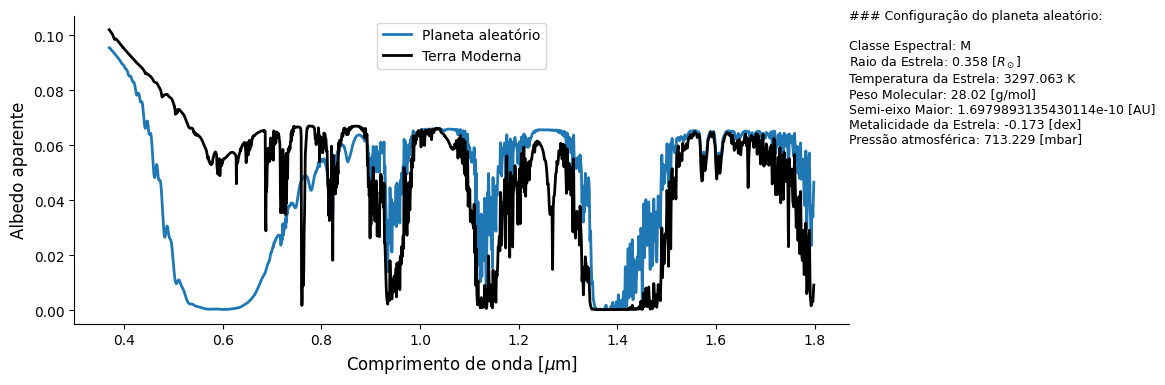

In [82]:
CLASSE_ESPECTRAL = aleatorio['OBJECT-STAR-TYPE']
RAIO_ESTRELA = aleatorio['OBJECT-STAR-RADIUS']
TEMPERATURA_ESTRELA = aleatorio['OBJECT-STAR-TEMPERATURE']
PESO_MOLECULAR = aleatorio['ATMOSPHERE-WEIGHT']
SEMI_EIXO_MAIOR = aleatorio['OBJECT-STAR-DISTANCE']
METALICIDADE_ESTRELA = aleatorio['OBJECT-STAR-METALLICITY']
PRESSAO_ATMO = aleatorio["ATMOSPHERE-PRESSURE"]

_, ax = plt.subplots()

spectrum_random.plotar_espectro(ax=ax, label="Planeta aleatório")
spectrum.plotar_espectro(ax=ax, cor_linha="k", label="Terra Moderna")
plt.legend(loc = "upper center")

texto = ("### Configuração do planeta aleatório:\n\n"
         f"Classe Espectral: {CLASSE_ESPECTRAL}\n"
         f"Raio da Estrela: {RAIO_ESTRELA} [$R_\odot$]\n"
         f"Temperatura da Estrela: {TEMPERATURA_ESTRELA} K\n"
         f"Peso Molecular: {PESO_MOLECULAR} [g/mol]\n"
         f"Semi-eixo Maior: {SEMI_EIXO_MAIOR} [AU]\n"
         f"Metalicidade da Estrela: {METALICIDADE_ESTRELA} [dex]\n"
         f"Pressão atmosférica: {PRESSAO_ATMO} [mbar]")

plt.text(1, 0.8, texto,
         horizontalalignment='left',
         verticalalignment='center',
         fontsize = 9, transform=plt.gca().transAxes)

plt.show()

## Gerando conjunto de dados

In [2]:
# Exemplo de diretório:
dir = "/home/sarah/Documentos/PSGCode"
datagen(nplanetas=5, dir=dir, nome_arq="datagen", instrumento="HWC", verbose=True)


****************************** MODO DE GERAÇÃO DE DADOS ******************************

Testing connection to PSG at https://psg.gsfc.nasa.gov/api.php ...
Connected to PSG with success.




Gerando planetas: 100%|██████████| 5/5 [00:47<00:00,  9.47s/planeta]


****************************** Arquivo salvo com sucesso! ******************************


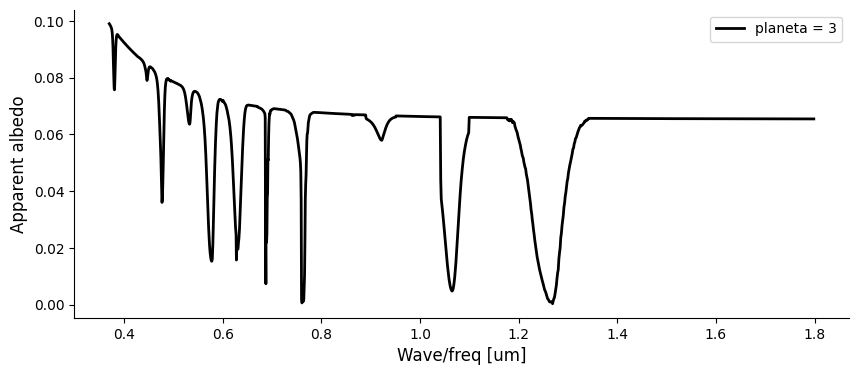

In [32]:
dados = '../data/datagen.parquet'
dados = pd.read_parquet(dados)

indice = np.random.randint(0, len(dados))
wave_freq = dados.iloc[indice]['Wave/freq [um]']
total_albedo = dados.iloc[indice]['Total [I/F apparent albedo]']

_, ax = plt.subplots()

ax.plot(wave_freq, total_albedo, label = f"planeta = {indice}", c = "k", lw = 2)
ax.set(xlabel="Wave/freq [um]", ylabel="Apparent albedo")
plt.legend();